# 빈도수와 유사도(Similarity)를 이용한 Embedding

In [1]:
import pandas as pd
from collections import defaultdict

## 샘플 데이터 준비
- 네이버 영화 평점 데이터 다운로드
- 참고 사이트: https://ratsgo.github.io/embedding/downloaddata.html

## 파일 업로드

In [2]:
with open('processed_ratings.txt') as f:
    lines = [l.strip() for l in f.read().splitlines() if l.strip()]

In [3]:
lines[:3]

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ',
 '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.',
 '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.']

## 필요한 함수 정의

### get_term_frequency

- 문장 내에서 TF (Term Frequency) 값을 구하는 함수

- 각 단어가 출현할 때마다 +1 증가

In [4]:

def get_term_frequency(document):
    term_freq = {}
    words = document.split()
    for w in words:
        term_freq[w] = 1 + (0 if term_freq.get(w) is None else term_freq[w])
    return term_freq

### get_context_counts

- 윈도윙(`windonwing`) 수행

- `vocab`에 포함된 각 단어가 각 문장에서 동시에 발견되는 횟수 카운트

In [5]:
# Windowing
# target word: vocab
def get_context_counts(lines, vocab, w_size=2) -> dict:
    context_cnt = defaultdict(int)
    # key값: (w, c), value값: 정수 (integer)
    # 모든 라인(한 줄)을 방문하면서 처리
    for line in lines:
        words = line.split()
        # 한 줄에 포함된 모든 단어를 검사
        for index, word in enumerate(words):
            # 어떤 단어가 검사하려는 문자열(vocab)에 포함되는지 검사
            if word in vocab:
                for word_in_window in words[index - w_size:index + w_size]:
                    if word != word_in_window:
                        context_cnt[(word, word_in_window)] += 1
            
    return context_cnt

### get_co_occurrence_df

- 동시에 출현한 단어의 빈도수를 계산하여 `pandas` `DataFrame`으로 리턴

In [6]:
# 동시출현 단어 빈도수 산출
# 산출된 n x n 크기의 dataFrame으로 리턴
def get_co_occurrence_df(context_cnt, vocab):
    data = []
    for word1 in vocab:
        row = []
        for word2 in vocab:
            try:
                count = context_cnt[(word1, word2)]
            except KeyError:
                count = 0
            row.append(count)
        data.append(row)
    return pd.DataFrame(data, index=vocab, columns=vocab)

### 각 단어의 출현 횟수 카운트

In [7]:
term_freq = pd.Series(
    get_term_frequency(' '.join(lines))
).sort_values(ascending=False)

term_freq

영화                 14435
너무                 11042
정말                 10378
진짜                  8029
이                   6795
                   ...  
드라마들이랑은                1
본드라마...다른              1
보고싶어지는!                1
허무했지만..ㅋㅋㅋ             1
포풍저그가나가신다영차영차영차        1
Length: 450540, dtype: int64

### 대부분의 단어는 극히 적은 수로 등장 $\to$ 빈도수가 작은 단어는 버림

In [8]:
vector_size = 800

In [9]:
term_freq.index[:vector_size]

Index(['영화', '너무', '정말', '진짜', '이', '영화.', '더', '왜', '그냥', '이런',
       ...
       '단순한', '서로', '맞는', '지금은', '않을', '가끔', '쓴', '느낌을', '시대를', '작품이'],
      dtype='object', length=800)

In [10]:
type(term_freq.index[:vector_size])

pandas.core.indexes.base.Index

### 일정 빈도수 이상인 단어를 이용해 context windowning 수행

In [11]:
context_cnt = pd.Series(
    get_context_counts(
        lines=lines,
        vocab=term_freq.index[:vector_size],
        w_size=4
    )
)

context_cnt

통해  외국디자이너와    1
    그들이        1
    일군         1
    전통을        1
    발전해가는      1
              ..
봐서  라따뚜이       1
    보고나서       1
    스머프        1
ㅋㅋ  스머프        1
    그런가        1
Length: 1238628, dtype: int64

Build Pandas DataFrame with given context-windowing result.

In [12]:
df = get_co_occurrence_df(context_cnt, term_freq.index[:vector_size])
df

,영화,너무,정말,진짜,이,영화.,더,왜,그냥,이런,...,단순한,서로,맞는,지금은,않을,가끔,쓴,느낌을,시대를,작품이
영화,0,271,388,215,409,76,130,93,143,189,...,4,3,10,2,12,12,10,6,4,2
너무,276,0,181,185,85,91,63,36,55,68,...,6,1,5,8,0,5,8,3,8,2
정말,400,184,0,102,169,152,50,55,43,87,...,2,2,3,2,5,1,2,3,1,4
진짜,235,190,108,0,99,41,43,66,52,61,...,0,1,2,2,0,1,1,1,1,4
이,481,88,164,99,0,61,72,134,49,32,...,3,3,5,2,3,1,8,5,3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
가끔,9,4,1,1,0,5,1,0,2,3,...,0,0,0,0,0,0,0,0,0,0
쓴,6,2,3,3,7,3,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
느낌을,6,4,3,1,6,3,3,0,0,2,...,0,0,0,0,0,0,1,0,0,0
시대를,6,9,1,1,3,3,2,0,0,2,...,0,0,0,1,0,0,0,0,0,0


In [13]:
df.values.shape

(800, 800)

# 시각화
- 문제점 발견 --> 대부분의 값이 0으로 채워진다.
- Dense Vector가 사실상 어렵다.
- 해결책: PCA 방법이 가능할 수도 있음

In [14]:
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
# 가능한 font list 확인
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
print(f)

['cmb10', 'STIXSizeOneSym', 'DejaVu Serif', 'STIXGeneral', 'STIXSizeTwoSym', 'DejaVu Sans', 'STIXSizeFourSym', 'DejaVu Sans Display', 'cmex10', 'STIXNonUnicode', 'cmr10', 'cmsy10', 'STIXSizeThreeSym', 'DejaVu Sans Mono', 'STIXSizeFiveSym', 'STIXGeneral', 'DejaVu Serif Display', 'STIXSizeOneSym', 'STIXSizeFourSym', 'cmtt10', 'DejaVu Sans Mono', 'DejaVu Serif', 'STIXGeneral', 'STIXNonUnicode', 'DejaVu Sans Mono', 'cmmi10', 'STIXSizeTwoSym', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeThreeSym', 'cmss10', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'Samyak Tamil', 'Lohit Odia', 'DejaVu Sans', 'Likhan', 'Garuda', 'NanumMyeongjo Eco', 'Nimbus Mono PS', 'Tlwg Typist', 'Tlwg Typewriter', 'Liberation Sans', 'Noto Sans CJK JP', 'Rasa', 'Laksaman', 'Ubuntu', 'Keraleeyam', 'Uroob', 'Quicksand Light', 'DejaVu Sans', 'KacstQurn', 'Samyak Devanagari', 'Norasi', 'Ubuntu Mono', 'Kinnari', 'Khmer OS System', 'DejaVu Sans', 'Padauk', '

<AxesSubplot:>

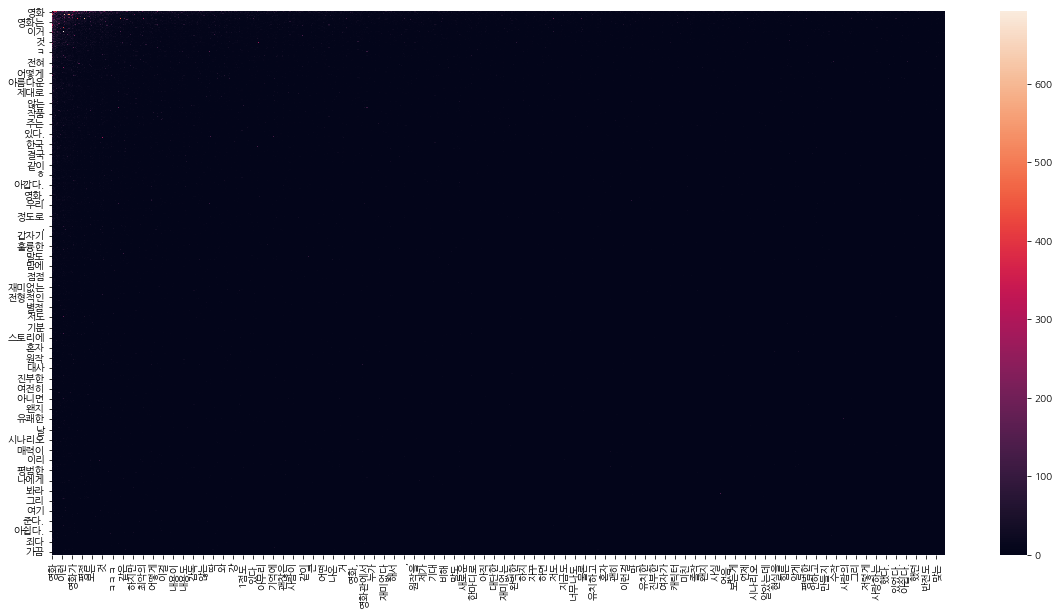

In [15]:
import seaborn as sns
plt.figure(figsize=(20,10))
plt.rc('font', family='NanumGothic')
sns.heatmap(df)